In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ephem
from category_encoders import TargetEncoder
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
import joblib
import json
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve

In [2]:
# --- Load and preprocess ---
df = pd.read_excel("combined.xlsx")
df = df.drop(columns=["Unnamed: 3"], errors='ignore')
df = df.dropna(subset=["Percentagediff", "Date"])

df['Target'] = df['Percentagediff'].apply(lambda x: 1 if x > 0 else 0)
target_label_map = {0: 'Negative', 1: 'Positive'}


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek

def moon_phase(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.phase

df['LunarPhase'] = df['Date'].apply(moon_phase)
df['NearFullMoon'] = (df['LunarPhase'] > 95).astype(int)
df['NearNewMoon'] = (df['LunarPhase'] < 5).astype(int)


C:\Users\ANKITH\AppData\Local\Temp\ipykernel_10148\4144099803.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [4]:
categorical_cols = ['Nakshatra', 'Tithi', 'Karna', 'Yoga']
df['Nak_Tithi'] = df['Nakshatra'].astype(str) + "_" + df['Tithi'].astype(str)
df['Yoga_Karna'] = df['Yoga'].astype(str) + "_" + df['Karna'].astype(str)
interaction_cols = ['Nak_Tithi', 'Yoga_Karna']
date_features = ['DayOfWeek']
moon_features = ['LunarPhase', 'NearFullMoon', 'NearNewMoon']

df['RollingMean_3'] = df['Percentagediff'].rolling(window=3).mean()
df['RollingStd_3'] = df['Percentagediff'].rolling(window=3).std()
df['PrevDayChange'] = df['Percentagediff'].shift(1)

In [5]:
for col in categorical_cols:
    agg = df.groupby(col)['Target'].mean().rename(f"{col}_target_mean")
    df = df.merge(agg, on=col, how='left')
extra_features = ['RollingMean_3', 'RollingStd_3', 'PrevDayChange'] + [f"{col}_target_mean" for col in categorical_cols]
feature_medians = {col: df[col].median() for col in extra_features}
feature_cols = categorical_cols + interaction_cols + date_features + moon_features + extra_features
df = df.dropna(subset=feature_cols + ['Target'])



In [6]:
encoder = TargetEncoder(cols=categorical_cols + interaction_cols)
df[categorical_cols + interaction_cols] = encoder.fit_transform(df[categorical_cols + interaction_cols], df['Target'])

X = df[feature_cols].values
y = df['Target'].values




Fold 1 Accuracy: 83.77%


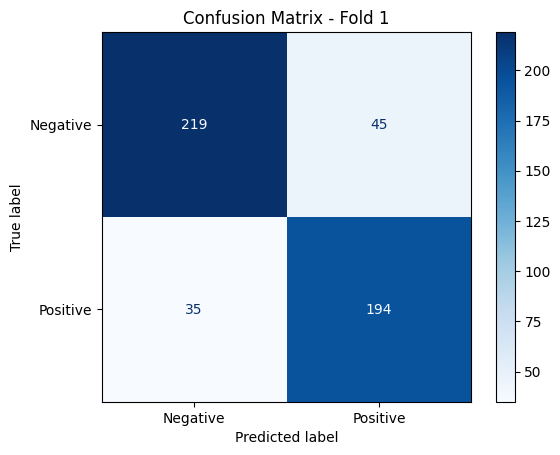


Fold 2 Accuracy: 81.74%


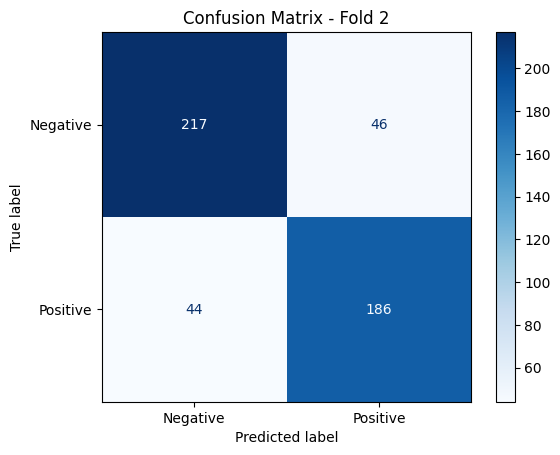


Fold 3 Accuracy: 83.98%


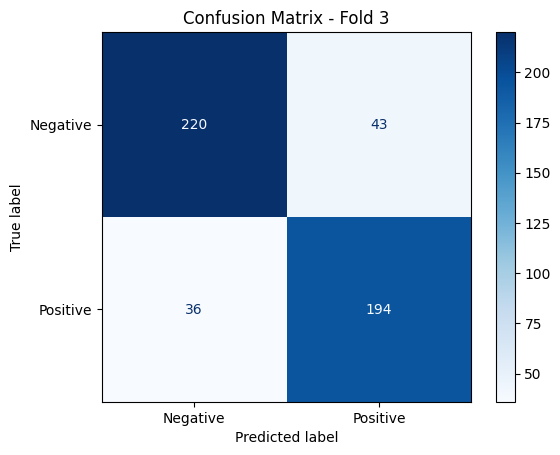


Fold 4 Accuracy: 83.98%


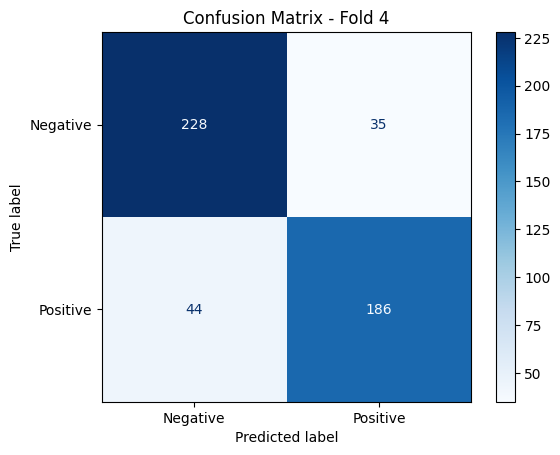


Fold 5 Accuracy: 76.06%


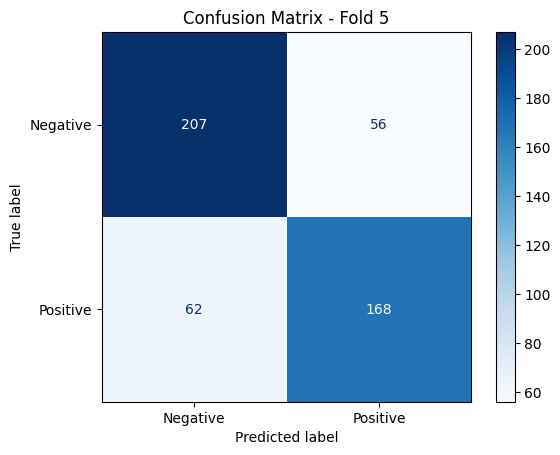

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
precision_list = []
recall_list = []
pr_auc_list = []
oof_true = []
oof_pred = []
oof_proba = []
conf_matrices = []

# --- Cross-validation with XGBoost ---
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
 try:
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    param_dist = {
        'n_estimators': randint(300, 1000),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.7, 0.3),
        'reg_alpha': uniform(0, 1.0),
        'reg_lambda': uniform(0, 1.0)
    }

    base_model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        verbosity=0
    )

    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=20,
        scoring='accuracy',
        cv=5,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train, y_train)
    model = search.best_estimator_
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    oof_true.extend(y_test)
    oof_pred.extend(y_pred)
    oof_proba.extend(y_proba)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    precision_list.append(precision)
    recall_list.append(recall)
    pr_auc = auc(recall, precision)
    pr_auc_list.append(pr_auc)

    conf_matrices.append(confusion_matrix(y_test, y_pred))

    acc = model.score(X_test, y_test)
    accuracies.append(acc)
    print(f"\nFold {fold} Accuracy: {acc * 100:.2f}%")
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=['Negative', 'Positive'], cmap='Blues')
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold}")
    plt.show()
 except Exception as e:
        print(f"Fold {fold} failed: {e}")



✅ Average Accuracy: 81.91%


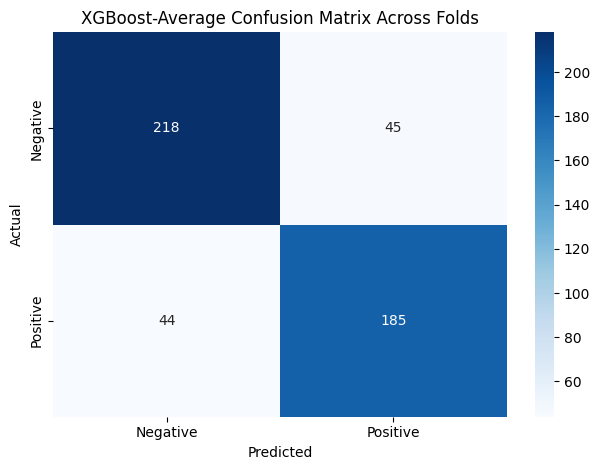

In [8]:

print(f"\n✅ Average Accuracy: {np.mean(accuracies) * 100:.2f}%")
avg_conf_matrix = np.mean(conf_matrices, axis=0).astype(int)
plt.figure()
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("XGBoost-Average Confusion Matrix Across Folds")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

C:\Users\ANKITH\AppData\Local\Temp\ipykernel_10148\311565896.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


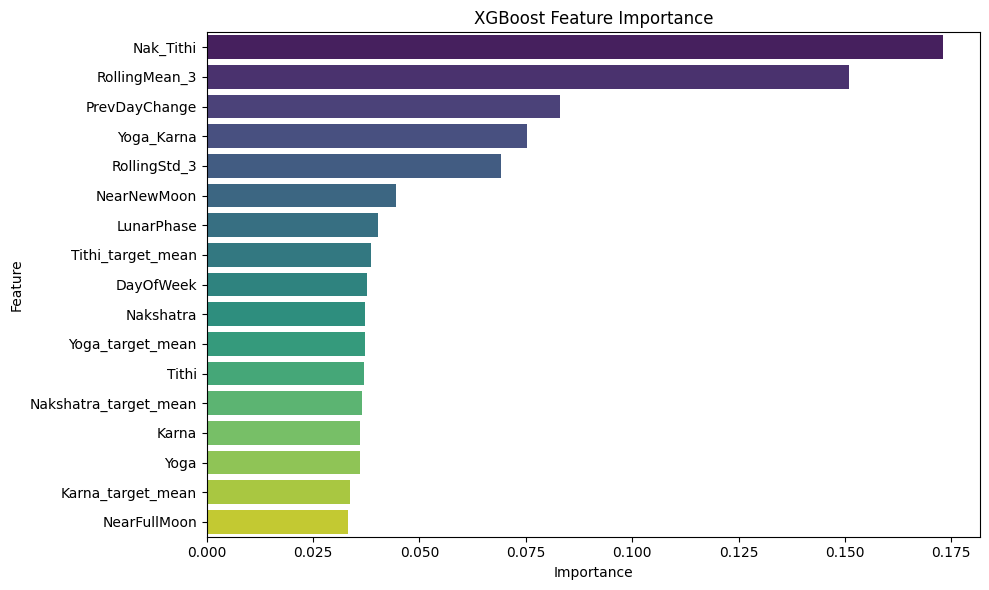

In [9]:
# --- Feature Importance ---
feature_importance = model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importance})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

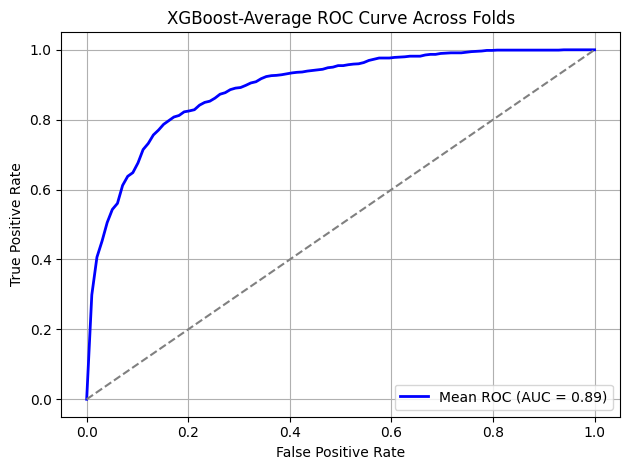

In [10]:
# --- ROC Curve ---
plt.figure()
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=f"Mean ROC (AUC = {mean_auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost-Average ROC Curve Across Folds")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

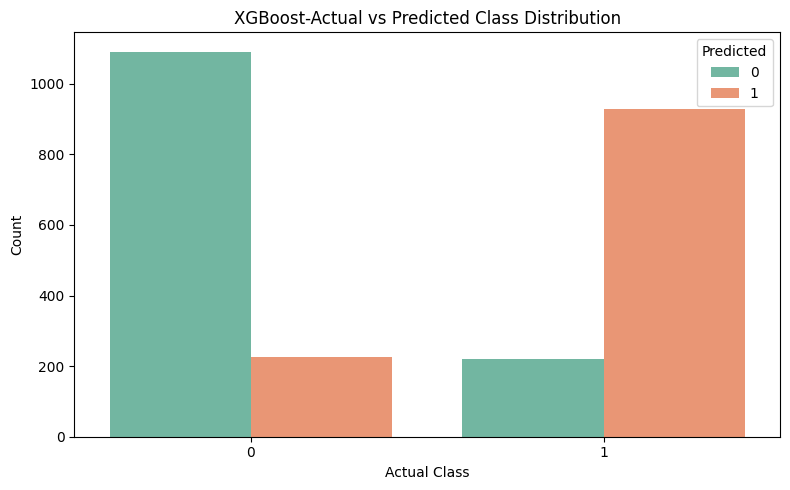

In [11]:
# --- Actual vs Predicted Countplot ---
df_plot = pd.DataFrame({'Actual': oof_true, 'Predicted': oof_pred})
df_plot['Match'] = df_plot['Actual'] == df_plot['Predicted']

plt.figure(figsize=(8, 5))
sns.countplot(data=df_plot, x='Actual', hue='Predicted', palette='Set2')
plt.title("XGBoost-Actual vs Predicted Class Distribution")
plt.xlabel("Actual Class")
plt.ylabel("Count")
plt.legend(title="Predicted")
plt.tight_layout()
plt.show()

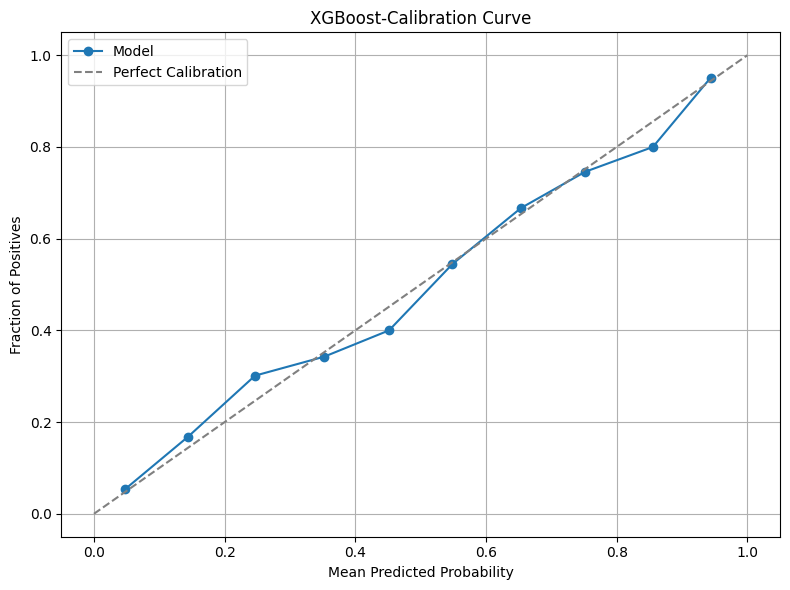

In [12]:
# --- Calibration Curve ---
prob_true, prob_pred = calibration_curve(oof_true, oof_proba, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("XGBoost-Calibration Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [43]:
# 🔮 Prediction
user_input = {
    'Nakshatra': 'Rohini',
    'Tithi': 'Dwadasi',
    'Karna': 'Kaulava',
    'Yoga': 'Vriddhi',
    'Date': '2025-07-21',
    'Percentagediff': 0  
}


In [44]:
user_input['Nak_Tithi'] = f"{user_input['Nakshatra']}_{user_input['Tithi']}"
user_input['Yoga_Karna'] = f"{user_input['Yoga']}_{user_input['Karna']}"
user_input['Date'] = pd.to_datetime(user_input['Date'])
user_input['DayOfWeek'] = user_input['Date'].dayofweek
user_input['LunarPhase'] = moon_phase(user_input['Date'])
user_input['NearFullMoon'] = int(user_input['LunarPhase'] > 95)
user_input['NearNewMoon'] = int(user_input['LunarPhase'] < 5)

user_df = pd.DataFrame([user_input])
user_df[categorical_cols + interaction_cols] = encoder.transform(user_df[categorical_cols + interaction_cols])

In [45]:
for col in extra_features:
    median_val = df[col].median()
    user_df[col] = median_val

user_encoded = user_df[feature_cols]
prediction = model.predict(user_encoded.values)[0]
label = target_label_map[int(prediction)]

print(f"\n📌 Prediction for input ({user_input['Nakshatra']}, {user_input['Tithi']}, {user_input['Karna']}, {user_input['Yoga']}): **{label}**")


📌 Prediction for input (Rohini, Dwadasi, Kaulava, Vriddhi): **Positive**
